In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

Task: MNIST dataset prediction


In [4]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [8]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
"""
.ToTensor() converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
.Normalize(mean, std) normalizes a tensor image with mean and standard deviation.  
"""
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])


# Download and load the training data
trainset = datasets.MNIST('~/datasets/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /home/shankara/datasets/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /home/shankara/datasets/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /home/shankara/datasets/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/shankara/datasets/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /home/shankara/datasets/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/shankara/datasets/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting /home/shankara/datasets/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/shankara/datasets/MNIST_data/MNIST/raw



In [13]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


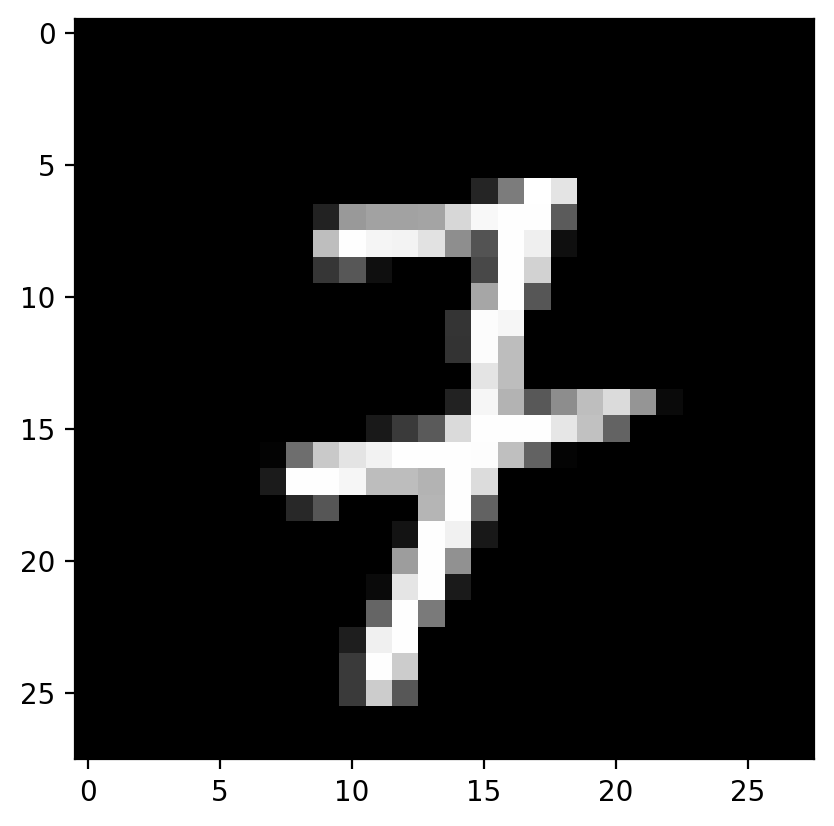

In [14]:
# example of one of the images in the dataset

plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

Exercise: Flatten the batch of images images. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next.

In [16]:
def activation(x):
    # sigmoid activation
    return 1/(1+torch.exp(-x))

# Flatten input images
inputs = images.view(images.shape[0], -1)

# Create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)

out = torch.mm(h, w2) + b2

print(out.shape)

torch.Size([64, 10])


Exercise: Implement a function softmax that performs the softmax calculation and returns probability distributions for each example in the batch. 

Note that you'll need to pay attention to the shapes when doing this. 

If you have a tensor a with shape (64, 10) and a tensor b with shape (64,), doing a/b will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. 

The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. 

So you need b to have a shape of (64, 1). This way PyTorch will divide the 10 values in each row of a by the one value in each row of b. 

Pay attention to how you take the sum as well. You'll need to define the dim keyword in torch.sum. Setting dim=0 takes the sum across the rows while dim=1 takes the sum across the columns.

In [17]:
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

# here out is the output of the last linear layer from the above code
probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)

# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


# Building networks with PyTorch

PyTorch provides a module nn that makes building networks much simpler.

In [18]:
from torch import nn


In [20]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [21]:


# Create the network and look at it's text representation
model = Network()
model



Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

You can define the network somewhat more concisely and clearly using the torch.nn.functional module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as F, import torch.nn.functional as F.

In [22]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

Exercise: Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the nn.ReLU module or F.relu function.

In [24]:
class Network(nn.Module):

    def __init__(self):
        super().__init__()

        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)

        return x
            



In [26]:
model = Network()

# print(model.fc1.weight)
# print(model.fc1.bias)

In [27]:
#  For custom initialization

# Set biases to all zeros
model.fc1.bias.data.fill_(0)

# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-0.0161, -0.0118, -0.0052,  ...,  0.0155, -0.0138,  0.0006],
        [ 0.0010,  0.0160, -0.0132,  ..., -0.0139,  0.0021,  0.0091],
        [ 0.0053, -0.0094,  0.0029,  ...,  0.0074, -0.0010,  0.0167],
        ...,
        [ 0.0001,  0.0087,  0.0030,  ..., -0.0012, -0.0124, -0.0068],
        [-0.0023, -0.0014,  0.0121,  ..., -0.0137,  0.0096,  0.0102],
        [ 0.0049, -0.0030,  0.0160,  ..., -0.0085, -0.0037,  0.0024]])

In [29]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

Forward Pass

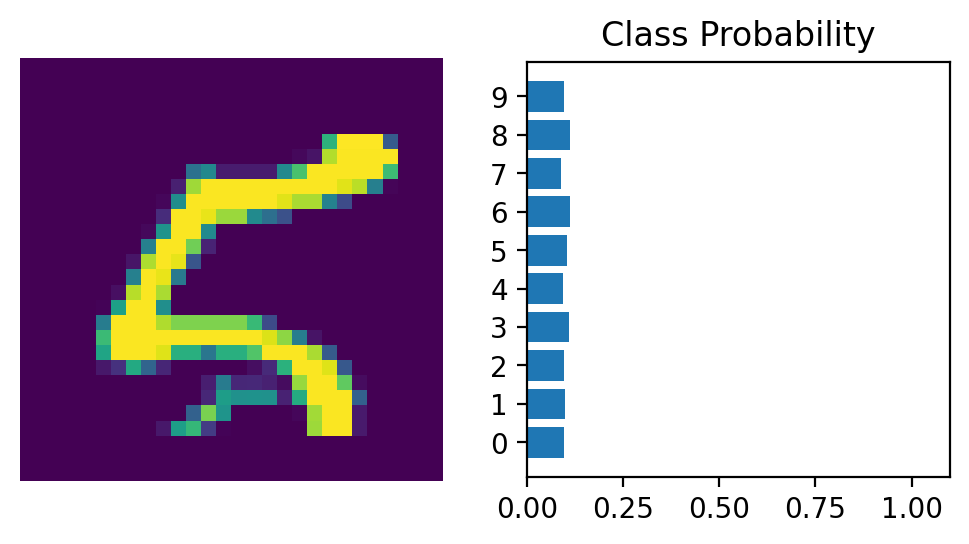

In [32]:
# Grab data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels)
images.resize_(64, 1, 784)

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)